This function aims to apply sigma-clipping to reject outlying data points in time-series data. The model iterativelty fits a smooth polynomial function (with the order as an input parameter) and rejects outliers beyond n-standard deviations of the fit (n is the second input parameter). The iterations end when no further poins are rejected or after a maximum of 100 is reached (the process should never take this long and a flag will raise if this occurs).

First import requried modiles.

In [1]:
import numpy as np
import scipy
import matplotlib.pylab as plt
import scipy.optimize as mcf
import scipy.signal as ssig
import matplotlib.gridspec as gridspec

Define the outlier rejection function. 


Arguments are as follows...

INPUTS: 
data_y_in, data_x_in --> 1D array containing the values of the time-series.



OPTIONAL INPUTS:

data_x_in            --> 1D arrays containing the time axis of the time-series (if no data_x_in entered, code assumes evenly spaced data).


sd_check             --> The number of standard deviations from the fitted model (see fname) to consider a point outliying.

fname                --> The type of smooth model to fit to the time series prior to rejection (linear, polynomial, running mean, running median).

filter_size          --> The size of the window to use for running mean and median computation (for running mean and median functions only).

max_iteration        --> Defines the stopping point for the sigma clipping (either when no further points are rejected or when max_iteration is reached).


diagnostic_figure    --> The name of an output figure showing the time-series with the outliers flagged. If blank ('') then no plot is made, else enter something like 'output_figure.pdf'

OUTPUTS:
data_x               --> The output time-stamps (will be the indicees of accepted points if no input provided).

data_y               --> The y-axis of accepted points in the time-series.

idx_out              --> The indicees of rejected points of the input time-series (data_y_in)

In [2]:
def outrej(data_y_in,data_x_in=[],sd_check=4,fname='running median',filter_size = 5,max_iteration = 10,
           diagnostic_figure='',comments=1):


 def func1(x,p0,p1):
  return(p0+x*p1)
 def func2(x,p0,p1,p2):
  return(p0+p1*x+p2*x**2)
 
 def movingaverage (x,y, window):
  weights = np.repeat(1.0, window)/window
  sma = np.convolve(y, weights, 'valid')
  sma_x = x[:]
  sma_y = np.concatenate((np.ones(window-1)*sma[0],sma))
  return(sma_x,sma_y)
 
 
 #if time values not provided, assume even sampling.
 if (type(data_x_in) == np.ndarray):
  data_x = np.array(data_x_in)
 else:
  ndat   = np.shape(data_y_in)[0]
  data_x = np.arange(ndat)
    
 data_y = np.array(data_y_in)
 out_x = []
 out_y = []
 idx_out = []
    
 #perform the iterations until max_iteration or no further rejections made   
 for iteration in range(max_iteration):
  
  #fit smooth function (linear, polynomial, running mean, running median, global median or global mean)
  if (fname == 'linear'): 
   popt, pcov = mcf.curve_fit(func1, data_x, data_y)
   model_y = popt[0] + data_x*popt[1]
   model_x = np.array(data_x)
  elif (fname == 'quadratic'):
   popt, pcov = mcf.curve_fit(func2, data_x, data_y)
   model_y = popt[0] + popt[1]*data_x + popt[2]*data_x**2
   model_x = np.array(data_x) 
  elif (fname == 'running median'):
   model_y = ssig.medfilt(data_y, kernel_size=filter_size)
   model_x = np.array(data_x)
  elif (fname = 'global median'):
   a =  np.median(data_y)
   model_y = a*np.ones(ndat)
   model_x = np.array(data_x)
  elif (fname == 'running mean'):
   model_x,model_y = movingaverage(data_x,data_y,filter_size)
  elif (fname = 'global mean'):
   a =  np.mean(data_y)
   model_y = a*np.ones(ndat)
   model_x = np.array(data_x)
 
  #compute the residuals ( abs[data-model])
  #model_itp = np.interpolate(data_x,model_x,model_y)   
  residual = data_y - model_y
 
     
  #identify points greater than sd_outlier from the model 
  sd = np.std(residual)
  id_out = np.where(np.abs(residual) > sd_check*sd)[0]
  n_out = np.shape(id_out)[0] 
 
     
  #flag outliers and remove from them from the data arrays for the next iteration
  #for id in id_out:
  # print data_x[id],data_y[id]
 
  out_x.append(data_x[id_out])
  out_y.append(data_y[id_out])
  data_x = np.delete(data_x,id_out)
  data_y = np.delete(data_y,id_out)
 
  #save a record of rejected array indicees 
  idx_out.append(id_out)

  #exit the loop prematurely if no outliers found
  if (np.shape(id_out)[0] == 0):
   if (comments == 1):
    print 'no further oultiers found after iteration ',iteration,' exiting...'
   break
  else:
   if (comments == 1):
    print 'iteration ',iteration,'\n ',n_out,'outliers found'
    
 #flag a warning if the outlier rejection has not converged after max_iteration iterations
 if ((iteration == max_iteration - 1) and (comments == 1)):
  print 'warning: Outlier rejection did not converge after a maximum,', max_iteration,\
 ' iterations re-run for more iterations or check input data for bugs'
 
    
    
 idx_out = np.array(np.concatenate(idx_out) ,dtype='int')  
 #plot a diagnostic plot if requested
 if (diagnostic_figure != ''):
  
  gs1 = gridspec.GridSpec(4, 4)
  gs1.update(left=0.1, right=0.9, bottom=0.1,top = 0.9, wspace=0.05,hspace = 0.0)
  ax1 = plt.subplot(gs1[:3, :])
  ax1.plot(data_x,data_y,label='Time series',color='k')
  ax1.plot(model_x,model_y,label='Smooth model',color='blue')
  ax1.scatter(data_x_in[idx_out],data_y_in[idx_out],marker='o',color='red',label='Outliers')
  plt.legend()
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Time-series values')
  
  axres = plt.subplot(gs1[3:, :])
  axres.plot(data_x,residual)
  axres.set_xlabel('Time')
  xl = list(axres.get_xlim())
  axres.set_xlim(xl)
  ax1.set_xlim(xl)
  axres.plot(xl,[0,0],ls=':')
  axres.set_ylabel('residuals \n (data - model)') 

  if (diagnostic_figure == 'show'):
   plt.show()
  else:
   plt.savefig(diagnostic_figure)
  plt.clf()
    
 return(data_y,data_x,model_y,idx_out)



Set 'demo_single_timeseries = 1' for a demonstration

In [3]:
demo_single_timeseries = 1

iteration  0 
  11 outliers found
iteration  1 
  1 outliers found
iteration  2 
  1 outliers found
no further oultiers found after iteration  3  exiting...


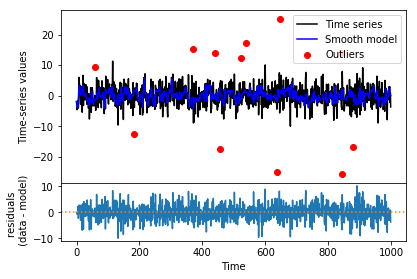

<Figure size 432x288 with 0 Axes>

In [4]:
if (demo_single_timeseries == 1):
 #generate some fake random data to test the code. Specify the parameters of the fake data below
 filter_size = 5
 fname = 'running median'
 sd_fake = 3.0
 n_fake  = 1000
 
 #some subset of the fake data will be the 'test outliers' the code is tasked to identify.
 #the parameters should be setup so that n_outlier < n_fake and sd_outlier > sd_fake.
 n_outlier = 23
 sd_outlier = 10.0
 
 data_y = np.random.randn(n_fake)*sd_fake
 id_test = np.random.choice(np.arange(n_fake), size=n_outlier, replace=False)
 data_y[id_test] = np.random.randn(n_outlier)*sd_outlier
 
 #also have the option of including irregularly spaced time-series data by speciffying a 
 #unique input array for the x-axis (code assumes regular sampling if no input)
 data_x = np.arange(n_fake)
 
 #Call the outlier rejection function defined above and test on the fake data.
 data_y_pass,data_x_pass,model_y,idx_outlier = outrej(data_y,data_x,sd_check=3.5,
 fname='running median',filter_size = 5,max_iteration=10,diagnostic_figure='show')

The function above is appropriate for identifying outliers from a single time series. With a few adaptions the function can allow for multiple time-series input.

The function below is apporpriate for cross-checking simultaneous epochs in adjacent time-series data using the sigma-clip routine in parallel epoch-by-epoch. This is useful 

In [5]:
#now define the paralel outlier rejection sigma clip
def outrej_paralel(data_y,sd_check=5,fname='running median',filter_size = 5,max_iteration=10,diagnostic_figure=''):
 


 n_epoch,n_timeseries = np.shape(data_y)

 #now compute the sigma-clip routine across parallel time series one time at a time
 id_outliers = np.zeros((2,0),dtype='int')
 for i in range(n_epoch):
  y_now = data_y[i,:]
  y_pass,x_pass,model,idx_outlier = outrej(y_now,sd_check=sd_check,fname=fname,
  filter_size = filter_size,max_iteration=max_iteration,diagnostic_figure='',
  comments=0)
  
  #save the points identified as outliers in a 2d array with 0th column corresponding to
  #time series ID and 1st column to the epoch id
  n_outliers = np.shape(idx_outlier)
  id_out = np.vstack( (np.ones(n_outliers,dtype='int')*i,idx_outlier) )
  id_outliers = np.hstack((id_outliers,id_out))
 id_outliers = id_outliers.T[:,[1,0]]
 
 
 #plot the results
 gs1 = gridspec.GridSpec(4, 4)
 gs1.update(left=0.1, right=0.9, bottom=0.1,top = 0.9, wspace=0.05,hspace = 0.0)
 ax1 = plt.subplot(gs1[:, :])
 for i in range(n_timeseries):
  if (i == 0):
   labts = 'Time series'
   labo  = 'Outliers'
  else:
   labts = None
   labo  = None
  ax1.plot(data_y[:,i],label=labts,color='k')
  id_ts = np.where(id_outliers[:,0] == i)[0]
  ax1.scatter(id_outliers[id_ts,1],data_y[id_outliers[id_ts,1],id_outliers[id_ts,0]],color='r',label=labo)
 plt.legend()
 ax1.set_title(np.str(n_timeseries)+' timeseries, ' + np.str(n_epoch) + ' epochs per series')
 ax1.set_xlabel('Time')
 ax1.set_ylabel('Time-series values')
 
 if (diagnostic_figure == 'show'):
  plt.show()
 else:
  plt.savefig(diagnostic_figure)
  
  
  
 return(id_outliers)

The demonstration below generates 'n_timeseries' sets of timeseries data, each with 'n_epoch' points. Anomalous variability is introduced in 'id_outlier' timeseries to simulate rogue outlying points. And the 'outrej_paralel' routine is asked to identify these.

Set 'demo_multi_timeseries = 1' for a demonstration of the paralel sigma clip routine

In [6]:
demo_multi_timeseries = 1

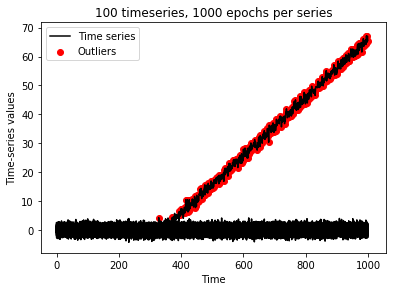

In [7]:
if (demo_multi_timeseries == 1):
 sd_background = 3.0
 n_epoch  = 1000
 n_timeseries = 100
 id_outlier = 23
 time_anomaly = 350
 grad_anomaly = 0.1
 diagnostic_figure = 'show'
 
 
 
 data_y = np.reshape( np.random.randn(n_epoch * n_timeseries), (n_epoch,n_timeseries) )
 
 
 
 
 #introduce a linear gradient into one timeseries to simulate non-stationarity
 data_y[time_anomaly:,id_outlier] += data_y[time_anomaly,id_outlier] + np.arange(0,n_epoch-time_anomaly,1)*grad_anomaly
 
 
 #test the paralel outlier rejection routine here
 op = outrej_paralel(data_y,sd_check=5,fname='running median',filter_size = 5,max_iteration=10,diagnostic_figure='show')


One final function to perform the outrej formulation in series rather than parallel. This is the same as the first function 'outrej' but accepts simultaneous multi light curve input.

In [ ]:
#now define the paralel outlier rejection sigma clip
def outrej_series(data_y,sd_check=5,fname='running median',filter_size = 5,max_iteration=10,diagnostic_figure=''):
 


 n_epoch,n_timeseries = np.shape(data_y)

 #now compute the sigma-clip routine across each time series one time at a time
 id_outliers = np.zeros((2,0),dtype='int')
 modelsave = []
 for i in range(n_timeseries):
  y_now = data_y[:,i]
  y_pass,x_pass,model,idx_outlier = outrej(y_now,sd_check=sd_check,fname=fname,
  filter_size = filter_size,max_iteration=max_iteration,diagnostic_figure='',
  comments=0)
  
  #save the smooth model
  modelsave.append(model)
  #save the points identified as outliers in a 2d array with 0th column corresponding to
  #time series ID and 1st column to the epoch id
  n_outliers = np.shape(idx_outlier)
  id_out = np.vstack( (np.ones(n_outliers,dtype='int')*i,idx_outlier) )
  id_outliers = np.hstack((id_outliers,id_out))
 id_outliers = id_outliers.T[:,[1,0]]
 
 
 #plot the results
 gs1 = gridspec.GridSpec(4, 4)
 gs1.update(left=0.1, right=0.9, bottom=0.1,top = 0.9, wspace=0.05,hspace = 0.0)
 ax1 = plt.subplot(gs1[:, :])
 for i in range(n_timeseries):
  if (i == 0):
   labts = 'Time series'
   labo  = 'Outliers'
   labmod = 'Smooth model'
  else:
   labts = None
   labo  = None
   labmod = None
  ax1.plot(data_y[:,i],label=labts,color='k')
  ax1.plot(modelsave[i],label=labts,color='b',label=labmod)
  id_ts = np.where(id_outliers[:,0] == i)[0]
  ax1.scatter(id_outliers[id_ts,1],data_y[id_outliers[id_ts,1],id_outliers[id_ts,0]],color='r',label=labo)
 plt.legend()
 ax1.set_title(np.str(n_timeseries)+' timeseries, ' + np.str(n_epoch) + ' epochs per series')
 ax1.set_xlabel('Time')
 ax1.set_ylabel('Time-series values')
 
 if (diagnostic_figure == 'show'):
  plt.show()
 else:
  plt.savefig(diagnostic_figure)
  
  
  
 return(id_outliers)

Now define a function to tie everything together

In [ ]:
def outlier_modsc(data_y,sd_check=5,fname='running median',runtype='series',filter_size = 5,max_iteration=10,diagnostic_figure=''):

 if (runtype=='parallel'):
   if (type(data_y)==np.ndarray):
    if (len(np.shape(data_y)) !=2):
     raise ValueError('For parallel outlier detection, \
     data_y must be a 2D numpy array with epochs as the first axis and \
     different light curves as the second')
  outrej_parallel(data_y,sd_check=sd_check,fname=fname,filter_size = filter_size,max_iteration=max_iteration,
                diagnostic_figure=diagnostic_figure)

 elif (runtype == 'series'):
  if (len(np.shape(data_y)) ==1):
    outrej(data_y,sd_check=sd_check,fname=fname,filter_size = filter_size,max_iteration = max_iteration,
           diagnostic_figure=diagnostic_figure,comments=0)
  else:
   outrej_series(data_y,sd_check=sd_check,fname=fname,filter_size = filter_size,max_iteration=max_iteration,
                diagnostic_figure=diagnostic_figure) 

 else:
  raise ValueError('Please ensure that the "runtype" argument is specified as either paralel or series and \\
  that the input data is in the form of either \n \
  1) A 1D numpy array for a single timeseries with epochs along the axis. or \n \
  2) A 2D numpy array for a data cube of multiple time series with epochs as the first axis and \
     different time series as the second.')
 